# Shor's Experiemnt in quantum computer

## Step 0: Import some libraries & initialize variable

In [ ]:
# Qiskit
## Step 1
from qiskit import QuantumCircuit
## Step 2 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# NOTE To save the api
service = QiskitRuntimeService(channel="ibm_quantum",
                              token="")
# QiskitRuntimeService.save_account(channel="ibm_quantum",
#                               token="")
## Step 3
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile

# Math
import numpy as np
import fractions
from math import gcd
from scipy.linalg import fractional_matrix_power


/var/folders/_w/jt_kf9wn083f9d6qv_cfhz500000gn/T/ipykernel_28943/32014747.py:8: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum",


In [120]:
n_target_wires = 4  # Number of qubits for the target register (4 for testing)
n_estimation_wires = 3  # Number of qubits for phase estimation (3 for testing)

## Step 1: Map the problem to the circuit

In [121]:
def qpe_circuit(matrix, n_target_wires, n_estimation_wires):
    """Construct the Quantum Phase Estimation circuit."""
    qc = QuantumCircuit(n_target_wires + n_estimation_wires, n_estimation_wires)

    # Prepare the target register in |1> state
    qc.x(0)

    # Apply Hadamard gates to the estimation qubits
    for wire in range(n_target_wires, n_target_wires + n_estimation_wires):
        qc.h(wire)

    # Apply controlled unitaries
    for idx in range(n_estimation_wires):
        power = 2 ** (n_estimation_wires - idx - 1)
        U_power = np.linalg.matrix_power(matrix, power)

        # Create a gate from the matrix and apply it as a controlled operation
        gate = QuantumCircuit(n_target_wires)
        gate.unitary(U_power, range(n_target_wires))
        controlled_gate = gate.control()
        qc.append(controlled_gate, [n_target_wires + idx] + list(range(n_target_wires)))

    # Apply the inverse Quantum Fourier Transform (QFT)
    for j in range(n_estimation_wires - 1, -1, -1):
        qc.h(n_target_wires + j)
        for m in range(j):
            angle = -np.pi / (2 ** (j - m))
            qc.cp(angle, n_target_wires + j, n_target_wires + m)
    

    # Measure the estimation qubits
    qc.measure(range(n_target_wires, n_target_wires + n_estimation_wires), range(n_estimation_wires))

    return qc

## Step 2: Optimize the problem for quantum execution

In [ ]:
backend_name = "ibm_brisbane"
backend = service.backend(backend_name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1  # Set the number of shots as needed

## Step 3: Execute on the backend

In [144]:
def get_phase(qc, sampler, n_estimation_wires):
    """Estimate the phase from the QPE circuit using the Runtime Sampler."""
    job = sampler.run([(qc, [])])
    result = job.result()
    pub_result = result[0]
    counts = pub_result.join_data().get_counts()
    most_likely_bitstring = max(counts, key=counts.get)
    decimal = int(most_likely_bitstring, 2)
    phase = decimal / (2 ** n_estimation_wires)
    return phase

def get_period(matrix, sampler, n_target_wires, n_estimation_wires, shots=5):
    """Estimate the period using multiple runs of phase estimation."""
    periods = []
    for _ in range(shots):
        qc = qpe_circuit(matrix, n_target_wires, n_estimation_wires)
        phase = get_phase(qc, sampler, n_estimation_wires)
        fraction = fractions.Fraction(phase).limit_denominator(2 ** n_estimation_wires)
        periods.append(fraction.denominator)
    return max(periods)

def get_matrix_a_mod_N(a, N):
    """Build the unitary matrix for modular multiplication a mod N."""
    dim = 2 ** n_target_wires
    U = np.zeros((dim, dim), dtype=complex)
    for x in range(dim):
        if x < N:
            y = (a * x) % N
        else:
            y = x
        U[y, x] = 1
    return U

## Step 3.1 For Testing Only !!!! (contain critical section)

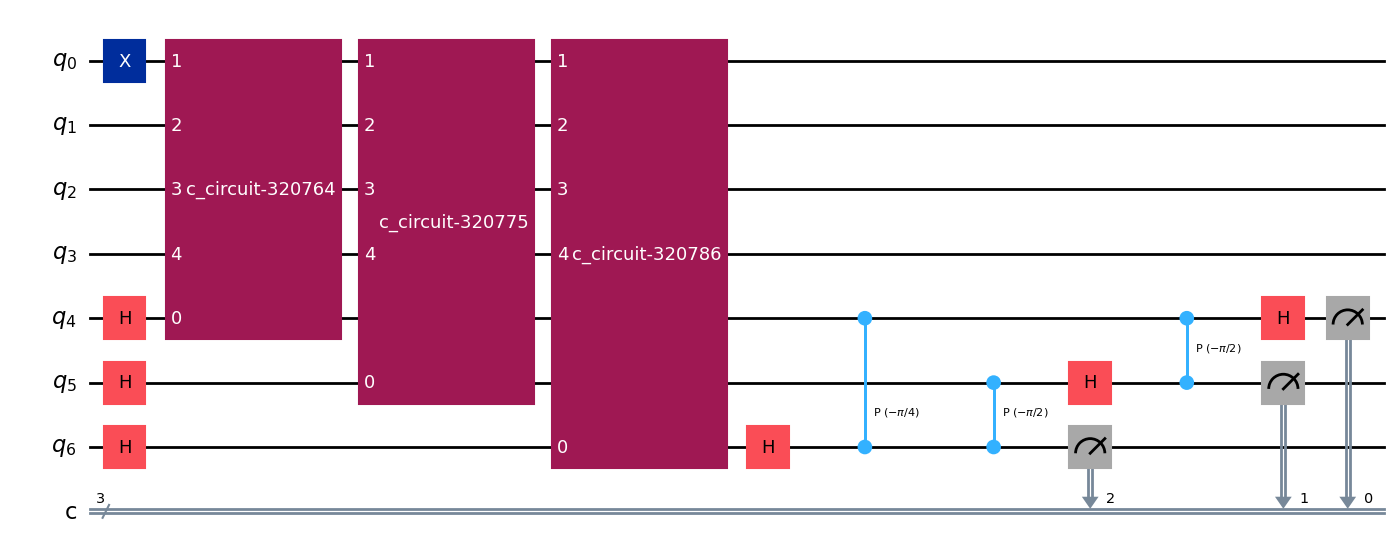

In [ ]:
# Settings For testing only
n_target_wires = 4
n_estimation_wires = 3
a = 4
N = 15

# Create unitary
U_na = get_matrix_a_mod_N(a, N)

# Generate QPE circuit
qc = qpe_circuit(U_na, n_target_wires, n_estimation_wires)

# Visualize (optional)
qc.draw('mpl')

In [145]:
## Critical section will lose your money !!!!!
transpiled_qc = transpile(qc, backend=backend, optimization_level=1)
phase = get_phase(transpiled_qc, sampler, n_estimation_wires=3)
print(f"Estimated phase: {phase}")

Estimated phase: 0.0
